# Random Forests & Ensembles

Nesse notebook vamos estudar técnicas para combinar o resultado de múltiplos modelos de forma a construir preditores mais poderosos e mitigar alguns dos problemas que surgem nos métodos que já estudamos

In [1]:
import matplotlib.pyplot as plt
import seaborn
import pandas as pd
import numpy as np

%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

import utils

In [3]:
np.random.seed(42)

plt.rcParams['figure.figsize'] = (8.0, 5.0)

## Relembrando sobre Árvores de Decisão

In [4]:
x, y, target_names = utils.load_dataset('cancer')

print('instancias X features:', x.shape)

instancias X features: (569, 30)


In [5]:
x.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [6]:
from sklearn.model_selection import train_test_split

xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=100, random_state=42)

In [8]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(criterion='entropy')
dt.fit(xtrain, ytrain)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [9]:
from sklearn.metrics import accuracy_score

ytrain_pred = dt.predict(xtrain)
ytest_pred = dt.predict(xtest)

print('Acurácia no treino:', accuracy_score(ytrain, ytrain_pred))
print('Acurácia no teste:', accuracy_score(ytest, ytest_pred))

Acurácia no treino: 1.0
Acurácia no teste: 0.94


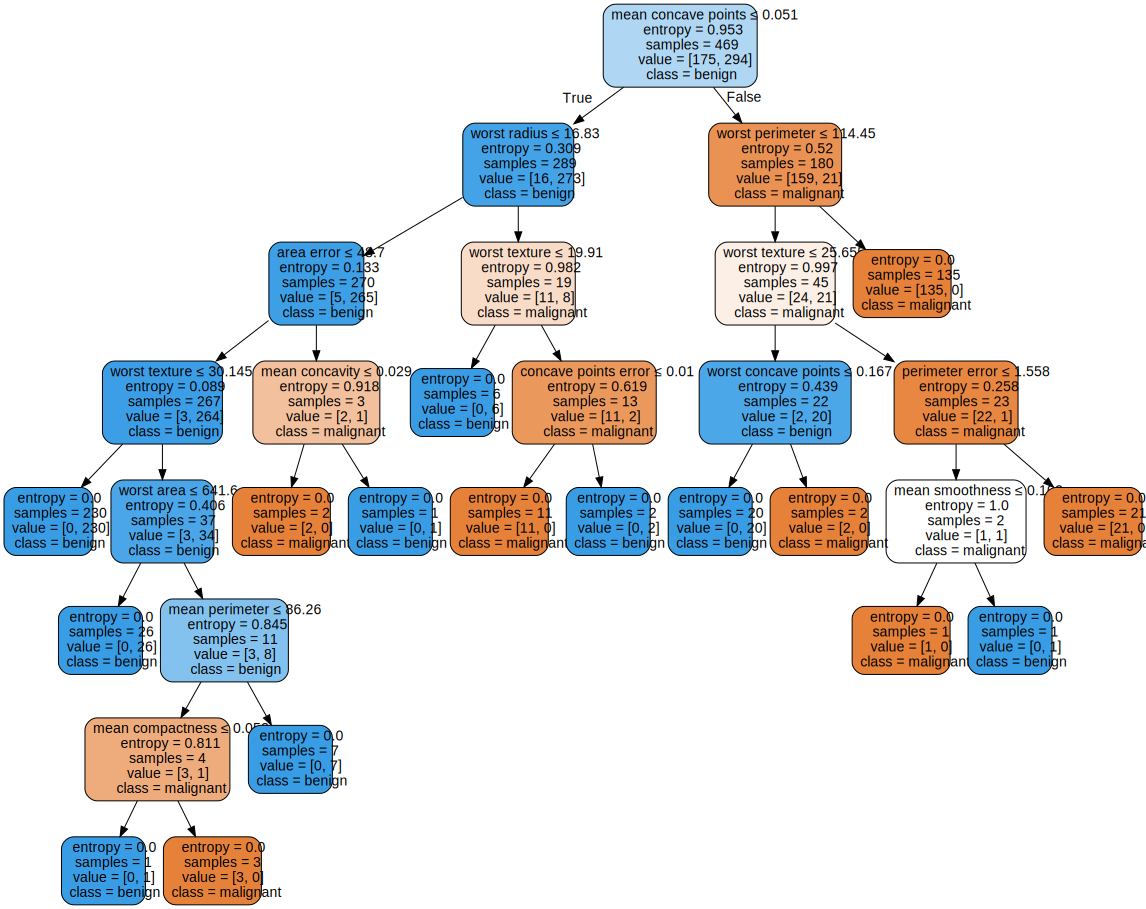

In [10]:
from sklearn.tree import export_graphviz
import graphviz

dot_data = export_graphviz(dt,
                           out_file=None,
                           feature_names=x.columns,
                           class_names=target_names,
                           filled=True, rounded=True, 
                           special_characters=True)
graphviz.Source(dot_data)

Obtivemos uma acurácia no teste de 94%, o que parece bem razoável. Vamos tentar de novo, mas vamos tirar o `random_state=42` do nosso `train_test_split`, o que vai fazer com que os nossos 150 exemplos de teste (e consequentemente os nossos exemplos de treino) sejam sempre diferentes:

In [16]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=150)

dt = DecisionTreeClassifier()
dt.fit(xtrain, ytrain)

accuracy_score(ytest, dt.predict(xtest))

0.95333333333333337

## Fronteiras de Decisão

Podemos visualizar as fronteiras de decisão de cada classificador treinado para entender melhor os erros que eles cometem:

In [18]:
sx = x[['mean concave points', 'worst perimeter']]

sx.head()

,mean concave points,worst perimeter
0,0.14710,184.60
1,0.07017,158.80
2,0.12790,152.50
3,0.10520,98.87
4,0.10430,152.20


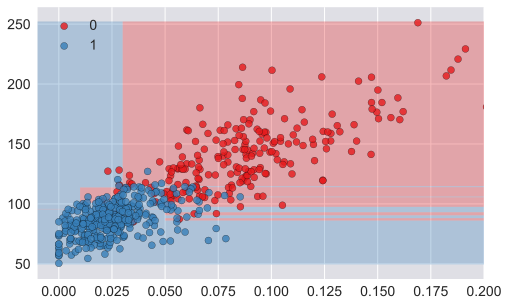

In [34]:
xtrain, xtest, ytrain, ytest = train_test_split(sx, y, test_size=150)

dt = DecisionTreeClassifier()
dt.fit(xtrain, ytrain)
    
utils.plot2d(sx.values, y.values, clf=dt)
plt.xlim((-0.01, 0.20))
plt.legend(loc=0)

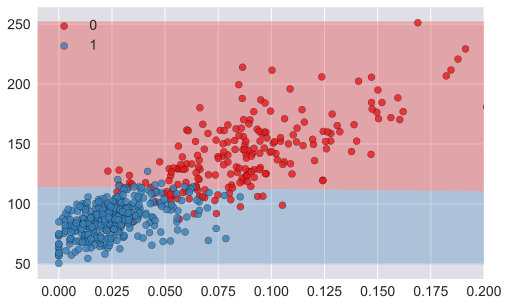

In [33]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(xtrain, ytrain)

utils.plot2d(sx.values, y.values, clf=lr)
plt.xlim((-0.01, 0.20))
plt.legend(loc=0)

## Combining (ensembling)

Temos vários classificadores treinados com árvores de decisão. Cada um deles é enviesado de uma forma diferente. Por que não combinar a opinião de todos eles?

In [35]:
def sample(x, y, f):
    sx = x.sample(frac=f)
    sy = y.loc[sx.index]
    return sx, sy

In [89]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=100)

accs = []
predictions = []
for r in range(1000):
    
    sx, sy = sample(xtrain, ytrain, 0.5)
    dt = DecisionTreeClassifier()
    dt.fit(sx, sy)
    ypred = dt.predict(xtest)
    predictions.append(ypred)
    

predictions = np.array(predictions)

In [90]:
ybag = np.mean(predictions, axis=0)>0.5
ybag

accuracy_score(ytest, ybag)
# print(np.mean(accs))

# combine!

0.95999999999999996

A técnica que acabamos de usar é um tipo de **ensembling**, mais especificamente um tipo de **bagging**. Nessa aula vamos aprender outras estratégias e formas mais fáceis de implementá-las.

## Random Forest

É muito simples utilizar random forest no nosso dataset:

In [105]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100)
rf.fit(xtrain, ytrain)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [106]:
ypred = rf.predict(xtest)
accuracy_score(ytest, ypred)

0.93999999999999995

## Exercício: Inadimplência

Nesse exemplo vamos carregar um dataset novo. Cada exemplo é uma pessoa que pediu uma linha de crédito e devemos decidir a probabilidade dessa pessoa nos pagar de volta, ou não. Algumas coisas que vocês devem fazer:

* Liste os atributos do problema.
* Observe se algum atributo é categório (não numérico).
* Observe se algum atributo tem dados faltantes (nulls e nans).
* Observe se o problema é balanceado (o que é isso mesmo?).
* Separe um conjunto de teste e um de treino (quanto pra cada?)
* Treine uma árvore de decisão, uma regressão logística e uma floresta aleatória.
* Utilizem a função `eval_auc` para estimar qual dos modelos acima é melhor.
* Observe o desempenho ao experimentar com o parâmetro `max_depth` (10, 20, 30, etc). Repare no tempo de execução também.
* Use o parâmetro `n_estimators` de `RandomForestClassifier` para ver como isso impacta o desempenho do seu modelo.
* Plote um gráfico `n_estimators` x `AUC` para sua random forest.
* A partir de qual valor de `n_estimators` você acha que não vale mais a pena aumentar?

In [109]:
from sklearn.metrics import roc_auc_score

def eval_auc(clf, x, y):
    ypred = clf.predict_proba(x)[:,1]
    return roc_auc_score(y, ypred)

In [116]:
x, y = utils.load_default()
x.head()

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [121]:
x.isnull().sum()

In [ ]:
x.dtypes

In [123]:
y.mean()

0.06684

In [124]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, stratify=y)

In [127]:
dt = DecisionTreeClassifier(max_depth=10)
dt.fit(xtrain, ytrain)

eval_auc(dt, xtest, ytest)

0.81734436012130784

In [130]:
lr = LogisticRegression()
lr.fit(xtrain, ytrain)

eval_auc(lr, xtest, ytest)

0.6828694472071295

In [138]:
estimators = range(5, 65, 5)
aucs = []
for ne in estimators:

#     print(ne)
    rf = RandomForestClassifier(max_depth=10, n_estimators=ne, n_jobs=-1)
    rf.fit(xtrain, ytrain)

    aucs.append(eval_auc(rf, xtest, ytest))

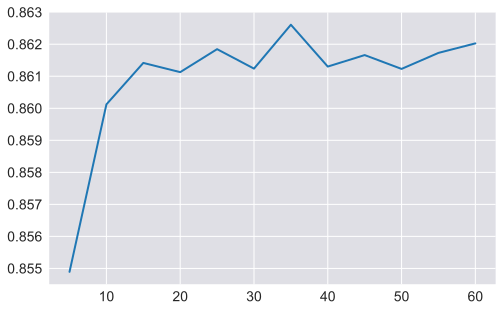

In [137]:
plt.plot(estimators, aucs)

## Ensembling

Nesse exercício vamos observar problemas de overfitting e underfitting e tentar criar ensembles simples parar mitigar tais problemas. Iremos juntos:

* Plotar os dados e observar a correlação entre x e y
* Utilizar `DecisionTreeRegressor` para treinar e visualizar um regressor nesses dados
* Experimentar com alguns parâmetros diferentes e observar os efeitos nos modelos
* Iterar N vezes para treinar N modelos diferentes com diferentes amostras dos dados
* Combinar os resultados de todos os modelos e observar o resultado

In [139]:
def sample(x, y, n):
    idx = np.random.randint(len(x), size=n)
    return x[idx], y[idx]

In [140]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split

x, y = utils.load_dataset('regression')

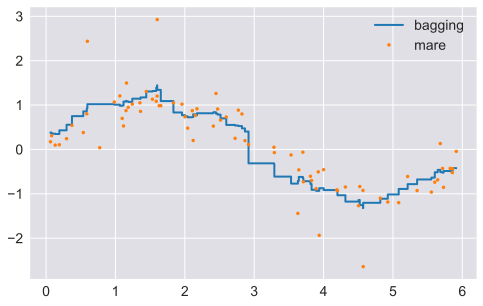

In [168]:
# N = 5
# train_sample = 0.5

predictions = []
for i in range(100):
    
    sx, sy = sample(x, y, 20)

    reg = DecisionTreeRegressor(max_depth=10)
    reg.fit(sx, sy)
    yp = reg.predict(x)
    predictions.append(yp)
    
#     plt.step(x, yp, '-')

    
p = np.array(predictions)
ybag = np.mean(p, axis=0)

plt.step(x, ybag, label='bagging')
plt.plot(x, y, '.', label="mare")
plt.legend()

## Bagging

Nesse exercício vamos experimentar usar a `BaggingClassifier` do sklearn para criar ensembles com regressão logística e árvores de decisão.

In [174]:
from sklearn.ensemble import BaggingClassifier

In [175]:
x, y = utils.load_dataset('default')

xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.3, stratify=y, random_state=1)

In [173]:
# dt = DecisionTreeClassifier(max_depth=10)
# bag = BaggingClassifier(dt, n_estimators=10)

# bag.fit(xtrain, ytrain)
# bag.predict(xtest)

In [172]:
from sklearn.metrics import roc_auc_score

n_estimators = [1,2,3,4,5,10,15,20]
dt_bag_scores = []
lr_bag_scores = []
for ne in n_estimators:
    dt = DecisionTreeClassifier(max_depth=15, random_state=1)
    lr = LogisticRegression(random_state=1)
    
    dt_bag = BaggingClassifier(dt, n_estimators=ne)
    lr_bag = BaggingClassifier(lr, n_estimators=ne)

    dt_bag.fit(xtrain, ytrain)
    lr_bag.fit(xtrain, ytrain)

    dt_bag_scores.append(eval_auc(dt_bag, xtest, ytest))
    lr_bag_scores.append(eval_auc(lr_bag, xtest, ytest))

    print(ne, dt_bag_scores[-1], lr_bag_scores[-1])


1 0.666839019077 0.684376075116
2 0.75965126922 0.701506150614
3 0.797905785404 0.702893485854
4 0.822225957332 0.704951905733
5 0.827831080825 0.703177172425
10 0.843088146476 0.703467057935
15 0.847881699794 0.702964658859
20 0.850565282287 0.70398067527


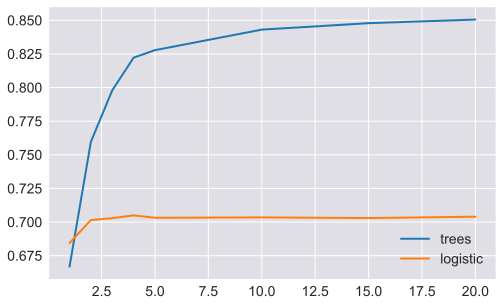

In [178]:
plt.plot(n_estimators, dt_bag_scores, label='trees')
plt.plot(n_estimators, lr_bag_scores, label='logistic')
plt.legend()

Esse resultado talvez deixe claro por que *random forests* são tão populares e não *random logistic regressions* não :)

## Voting

Vamos usar o `VotingClassifier` do `sklearn` para compor alguns classificadores diferentes.

In [179]:
x, y = utils.load_dataset('default')

xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.3, stratify=y, random_state=1)

In [184]:
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier

dt1 = DecisionTreeClassifier(random_state=1)
dt2 = DecisionTreeClassifier(max_depth=12, max_features=5, random_state=42)
lr1 = LogisticRegression()
lr2 = LogisticRegression(C=0.001, penalty='l1')
knn = KNeighborsClassifier()

clfs = [('dt1', dt1),
        ('dt2', dt2),
        ('lr1', lr1),
        ('lr2', lr2),
        ('knn', knn)]

vot = VotingClassifier(clfs, voting='soft')
vot.fit(xtrain, ytrain)

VotingClassifier(estimators=[('dt1', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_lea...owski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'))],
         flatten_transform=None, n_jobs=1, voting='soft', weights=None)

In [185]:
for name, clf in clfs:
    clf.fit(xtrain, ytrain)
    
    auc = eval_auc(clf, xtest, ytest)
    print(name, auc)
    
print()
print('all', eval_auc(vot, xtest, ytest))

dt1 0.608842140619
dt2 0.776249229526
lr1 0.702939934354
lr2 0.655508902183
knn 0.577998903445

all 0.786149402381


dt1 0.608842140619
dt2 0.776249229526
lr1 0.701278412833
lr2 0.651564801445
knn 0.577998903445

all 0.784961581145


## Mini-competição!

Vamos usar os métodos que aprendemos pra tentar melhorar nosso resultado nesse dataset de inadimplência! Usem a criatividade :)

In [188]:
x, y = utils.load_dataset('default')

xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.3, stratify=y, random_state=1)

In [192]:
clf = DecisionTreeClassifier(max_depth=7)
clf.fit(xtrain, ytrain)

eval_auc(clf, xtest, ytest)

0.84052735918797095

In [199]:
clf = RandomForestClassifier(max_depth=8, n_estimators=200)
clf.fit(xtrain, ytrain)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [197]:
clfs = [('dt1', RandomForestClassifier(max_depth=9, n_estimators=20)),
        ('dt2', RandomForestClassifier(max_depth=8, n_estimators=20)),
        ('lr1', RandomForestClassifier(max_depth=7, n_estimators=20)),
        ('lr2', RandomForestClassifier(max_depth=10, n_estimators=20)),
        ('knn', RandomForestClassifier(max_depth=11, n_estimators=20))]

vot = VotingClassifier(clfs, voting='soft')
vot.fit(xtrain, ytrain)

VotingClassifier(estimators=[('dt1', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=9, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weig...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))],
         flatten_transform=None, n_jobs=1, voting='soft', weights=None)

In [200]:
eval_auc(clf, xtest, ytest)

0.86057797815718695

## Stacking

Vamos usar os mesmos estimadores base do exemplo anterior, porém ao invés de definir a predição por voto, vamos **treinar outro classificador com as predições dos classificadores base**. Primeiro começamos com nosso split train/test padrão:

In [ ]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.3, stratify=y, random_state=1)

Agora precisamos fazer um novo split no conjunto de treino para reservar dados para nosso meta-learner.

In [ ]:
xbase, xmeta, ybase, ymeta = train_test_split(xtrain, ytrain, test_size=0.5, random_state=1)

In [ ]:
xmeta_preds = pd.DataFrame(index=ymeta.index)

# ...

In [ ]:
meta_clf = DecisionTreeClassifier(max_depth=7, random_state=1)
# ...

In [ ]:
xtest_meta = pd.DataFrame(index=ytest.index)

# ...

In [ ]:
eval_auc(meta_clf, xtest_meta, ytest)

## De volta ao Kaggle!

![Comp](taxi-competition.png)

Vamos utilizar as técnicas que aprendemos para treinar modelos pra prever quanto tempo uma viagem de taxi em NY vai levar. Depois vamos submeter nossa solução para o Kaggle.

Dessa vez é pra ganhar!!

In [203]:
df = pd.read_csv('../data/kaggle/train.csv')

In [204]:
print('Instances x features:', df.shape)
df.head()

Instances x features: (1458644, 11)


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


Lembrando que já vimos que não precisamos imputar (han??) nenhuma feature:

In [205]:
df.isnull().sum(axis=0)

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

Porém precisamos lidar com algumas variáveis não numéricas:

In [206]:
df.dtypes

id                     object
vendor_id               int64
pickup_datetime        object
dropoff_datetime       object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
trip_duration           int64
dtype: object

Vamos dar uma relembrada rápida na distribuição nosso target (tempo de viagem):

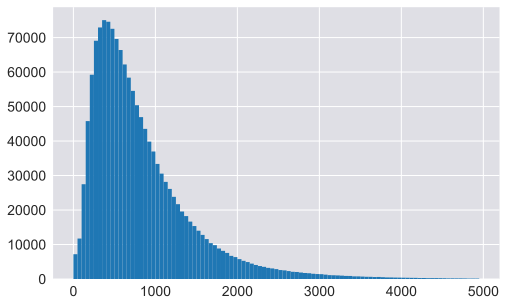

In [207]:
df.trip_duration.hist(bins=range(0,5000,50))

Agora vamos criar nossas features e nosso target:

In [208]:
x = df.drop(['trip_duration', 'id', 'pickup_datetime', 'dropoff_datetime', 'store_and_fwd_flag'], axis=1)
y = df['trip_duration']

In [209]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.1, random_state=1)

In [232]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

reg = RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1)
reg.fit(xtrain, ytrain)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [233]:
from sklearn.metrics import mean_absolute_error, mean_squared_log_error

def rmsle(ytrue, ypred):
    return np.sqrt(mean_squared_log_error(ytrue, ypred))

In [234]:
ypred = reg.predict(xtest)

In [235]:
print(mean_absolute_error(ytest, ypred)/60)

print(rmsle(ytest, ypred))

7.95534569628
0.617761472725


In [236]:
# print(mean_absolute_error(ytest, ypred)/60)
# print(rmsle(ytest, ypred))

### Submission

Para montar nossa submissão precisamos:

* Carregar o arquivo CSV
* Aplicar o mesmo pre-processamento que fizemos no treino (que ainda é bem simples)
* Fazer as predições
* Montar e salvar um arquivo CSV

In [237]:
df_sub = pd.read_csv('../data/kaggle/test.csv')

In [238]:
x_sub = df_sub.drop(['id', 'pickup_datetime', 'store_and_fwd_flag'], axis=1)

In [239]:
y_sub = reg.predict(x_sub)

In [240]:
sub = pd.DataFrame({'id': df_sub.id, 'trip_duration': y_sub})
sub.to_csv('../data/kaggle/sub_monstro.csv', index=False)